In [1]:
%matplotlib inline
!pip install thop

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from thop import profile
from torchsummary import summary


# training a model first

In [2]:
use_cuda = True


In [5]:
NUM_MODEL_RUNS = 3
EPOCHS = 10

In [6]:

def find_res_fixed_params_pool(N1, C1, S1, P1, C2, S2, P2):
  '''
    Keeping the number of parameters the same using a pooling layer
    Approach II in the paper
  '''
  num_solutions = 0
  Solutions = []

  M1 = int((N1 - C1 + 2*P1) / S1 + 1) # output size after conv 1 
  # M1 = (N1 - C1 + 2*P1) / S1

  for N2 in np.arange(N1+1,29,2): # new resolution
    for F in np.arange(2,6): # pooling kernel size
      for S in np.arange(1,3): # stride in pool layer
        for P in np.arange(F//2): # padding in pool layer
          # W1 = (N2 - C1 + 2*P1) / S1
          # M2 = (W1 - F + 2*P)  / S
          W1 = int((N2 - C1 + 2*P1) / S1 + 1)
          M2 = int((W1 - F + 2*P)  / S + 1)

          if M1 == M2: #continue

          # print(f'1st layer old: inp res: {N1}, filter size: {C1}, num filters: {K1}, out res: {M1}, stride: {S1}, pad: {P1}')
          # print(f'1st layer new: inp res: {N2}, filter size: {C1}, num filters: {K1}, out res: {M1}, stride: {S1}, pad: {P1}')
          # print(f'pooling layer: inp res: {M1}, filter size: {F},  out res: {M2}, stride: {S}, pad: {P}')
          # params_old = (K1 * C1**2 * 1) 
          # params_new = (K1 * C1**2 * 1) 
          # # print(f'PARAMs old: {params_old}, PARAMs new: {params_new}\n')

          # assert params_old==params_new, False

            num_solutions += 1
            Solutions.append({'im_res_orig':N1, 'im_res_new':N2, 'layer1':[C1, S1, P1], 'layer2':[C2, S2, P2], 'pool_layer':[F, S, P]})

  # print(f'num solutions: {num_solutions}')
  return Solutions  



In [7]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img


class NetTest(nn.Module):
    def __init__(self, im_res=28, conv1_size=3, conv2_size=3, pool1_size=2, pool2_size=2, num_conv1=10, num_conv2=10, stride_1=1, stride_2=1, padd_1=0, padd_2=0, num_hid=50, pool_layer=None):
        super(NetTest, self).__init__()
        # import pdb; pdb.set_trace()
        self.conv1 = nn.Conv2d(1, num_conv1, kernel_size=conv1_size, stride=stride_1, padding=padd_1, bias=True)
        self.res_conv1 = int((im_res - conv1_size + 2*padd_1) / stride_1 + 1)

        # plug the new pooling layer
        self.new_pool_layer = pool_layer
        if self.new_pool_layer:
          self.res_conv1 = int((self.res_conv1 - self.new_pool_layer[0] + 2*self.new_pool_layer[2]) / self.new_pool_layer[1] + 1)


        # self.res_pool1 = int((self.res_conv1 - pool1_size + 2*0) / pool1_size + 1)                

        self.conv2 = nn.Conv2d(num_conv1, num_conv2, kernel_size=conv2_size, stride=stride_2, padding=padd_2, bias=True)
        
        # print(stride_2)
        self.res_conv2 = int((self.res_conv1 - conv2_size + 2*padd_2) / stride_2 + 1 )       
        # self.res_pool2 = int((self.res_conv2 - pool2_size + 2*0) / pool2_size + 1)               
        
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear((self.res_conv2**2)*num_conv2, num_hid, bias=True)        
        self.fc2 = nn.Linear(num_hid, 10, bias=True)
        self.pool1_size = pool1_size
        self.pool2_size = pool2_size
        self.num_conv2 = num_conv2
        self.im_res = im_res


        
    def forward(self, x):
        # import pdb; pdb.set_trace()
        tmp1 = F.relu(self.conv1(x))
        if self.new_pool_layer:
          tmp1 = F.relu(F.max_pool2d(tmp1, kernel_size=self.new_pool_layer[0], stride=self.new_pool_layer[1], padding=self.new_pool_layer[2] ))

        # tmp1 = F.relu(F.max_pool2d(tmp1, self.pool1_size))
        # tmp1 = F.relu(tmp1)
        tmp = F.relu(self.conv2_drop(self.conv2(tmp1)))
        # x = F.avg_pool2d(tmp, kernel_size=tmp.shape[-1])
        # x = x[:,:,0,0]

        x = tmp.view(-1, (self.res_conv2**2)*self.num_conv2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x   ### SUPER IMPORTANT ***************************** works with cross entropy loss loss now

device = 'cuda'

In [8]:
# F.max_pool2d?

In [9]:
# c = 6
# p = 3
# s = 2
# assert 20 == (28 - c + 2*p) / s + 1, False
# 19 = 22 + 2*6 
# import cv2


In [10]:
def train_model(model):

  # EPOCHS = 1
  losses = []

  optimizer = optim.Adadelta(model.parameters())

  model.train()
  for epoch in range(EPOCHS):
      for batch_idx, (data, target) in enumerate(train_loader):
          
          data, target = data.to(device), target.to(device)        
          optimizer.zero_grad()
          y_pred = model(data) 

          # import pdb; pdb.set_trace()
          loss = F.cross_entropy(y_pred, target)
          losses.append(loss.cpu().data)

          loss.backward()
          optimizer.step()
          
          # Display
          if batch_idx % 100 == 1:
              print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch+1,
                  EPOCHS,
                  batch_idx * len(data), 
                  len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), 
                  loss.cpu().data), 
                  end='')

  # Eval
  # model.eval()
  # Eval
  model.eval()
  correct = total = 0
  for idx, (images, labels) in enumerate(test_loader):
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      _, pre = torch.max(outputs.data, 1)

      total += len(labels)
      correct += (pre == labels).sum()

  accuracy = float(correct) / total
  print('Test Accuracy: %f %%' % accuracy)
  # return acc


  # import pdb; pdb.set_trace()
  # evaluate_x = test_loader.dataset.test_data.type_as(torch.FloatTensor()).to(device)
  # evaluate_y = test_loader.dataset.test_labels.to(device)

  # output = model(evaluate_x[:,None,...])
  # pred = output.data.max(1)[1]
  # d = pred.eq(evaluate_y.data).cpu()
  # accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
  
  print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
      epoch+1,
      EPOCHS,
      len(train_loader.dataset), 
      len(train_loader.dataset),
      100. * batch_idx / len(train_loader), 
      loss.cpu().data,
      accuracy*100,
      end=''))
  

  return accuracy

In [11]:
# sol_3

In [12]:
def evaluate_orig_model(sol):

  # run the original model for a couple of times
  sol['orig_solutions'] = []

  cv1_size = sol['layer1'][0]
  st1 = sol['layer1'][1]
  pd1 = sol['layer1'][2]

  cv2_size = sol['layer2'][0]
  st2 = sol['layer2'][1]
  pd2 = sol['layer2'][2]


  im_res = sol['im_res_orig']

  global train_loader
  global test_loader
  
  train_loader = torch.utils.data.DataLoader(
      datasets.FashionMNIST('../data', train=True, download=True, transform=transforms.Compose([
              transforms.ToTensor(),transforms.Resize((im_res, im_res)),])), batch_size=100, shuffle=True)

  test_loader = torch.utils.data.DataLoader(
      datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
              transforms.ToTensor(),transforms.Resize((im_res, im_res)),])), batch_size=100, shuffle=True)

  # for run_no in range(1):
  # try:
      # print(f'----  im_res={im_res_new}, conv1_size={cv1_size}, conv2_size={cv2_size}')
  # import pdb; pdb.set_trace()
  accs = []
  for i in range(NUM_MODEL_RUNS):
    model = NetTest(im_res=im_res, conv1_size=cv1_size, stride_1=st1, padd_1=pd1, conv2_size=cv2_size, stride_2=st2, padd_2=pd2).to(device)
    if i==0:
      macs, params = profile(model, inputs=(torch.randn(1, 1, im_res, im_res).to(device), ))
    accs.append(train_model(model))
  
  sol['orig_solutions'].append((macs, params, np.mean(accs)))
  # accuracies.append((sol, macs, params, acc))
  # print(accuracies[-1])
  print(sol, '\n')

  # except:
  #   print('\n Model invalid')


  return #sol


In [13]:
def evaluate_new_model(sols):
  # running the solutions; one by one; three each
  # for run_no

  for sol in sols:
        im_res = sol['im_res_new']
        
        cv1_size = sol['layer1'][0]
        st1 = sol['layer1'][1]
        pd1 = sol['layer1'][2]

        cv2_size = sol['layer2'][0]
        st2 = sol['layer2'][1]
        pd2 = sol['layer2'][2]

        pool_lyr = sol['pool_layer']
        sol['new_solutions'] = []

        global train_loader
        global test_loader

        train_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST('../data', train=True, download=True, transform=transforms.Compose([
                    transforms.ToTensor(),transforms.Resize((im_res, im_res)),])), batch_size=100, shuffle=True)

        test_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
                    transforms.ToTensor(),transforms.Resize((im_res, im_res)),])), batch_size=100, shuffle=True)


        # for run_no in range(1):
        # try:
          # print(f'----  im_res={im_res_new}, conv1_size={cv1_size}, conv2_size={cv2_size}')
        # import pdb; pdb.set_trace()  
        accs = []
        for i in range(NUM_MODEL_RUNS):
          model = NetTest(im_res=im_res, conv1_size=cv1_size, stride_1=st1, padd_1=pd1, conv2_size=cv2_size, stride_2=st2, padd_2=pd2, pool_layer=pool_lyr).to(device)
          if i==0:
            macs, params = profile(model, inputs=(torch.randn(1, 1, im_res, im_res).to(device), ))
          accs.append(train_model(model))
        
        # which_model = 'new_res' if a else 'orig_res'
        # sol[which_model] = (macs, params, acc)
        sol['new_solutions'].append((macs, params, np.mean(accs)))
        # accuracies.append((sol, macs, params, acc))
        # print(accuracies[-1])
        print(sol, '\n')

        # except:
        #   print('\n Model invalid')

  
  return #sols

In [14]:
# np.arange(3,8,2)

In [ ]:
import random 
all_res = {}

for N1 in [12]:#12,16,20,24]:
  all_solutions = []
  for C1 in np.arange(3,6,2): # filter size layer 1 
    for S1 in np.arange(1,3): # stride layer 1    
      for P1 in np.arange(4): # padding layer 1
        for C2 in np.arange(3,6,2): # filter size layer 1 
          for S2 in np.arange(1,3): # stride layer 1    
            for P2 in np.arange(4): # padding layer 1
              xx = find_res_fixed_params_pool(N1, C1, S1, P1, C2, S2, P2)
              if xx:
                all_solutions.append(xx)
  
  results = []
  random.shuffle(all_solutions)
  all_solutions.sort(key=len, reverse=True)
  all_solutions = all_solutions[:10]
  for idx, sol_3 in enumerate(all_solutions):
    print(f'\n --------------------- solution no {idx} -------------------- \n')
    if len(sol_3) > 4:
      sol_3 = sol_3[-4:]

    evaluate_orig_model(sol_3[0])
    if not sol_3[0]['orig_solutions']:
      break

    evaluate_new_model(sol_3)
    xx = (sol_3[0]['orig_solutions'][0], [sol['new_solutions'][0][-1] for sol in sol_3 if sol['new_solutions']])

    results.append(xx)

  all_res[N1] = results          
print(len(all_solutions))


 --------------------- solution no 0 -------------------- 

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.dropout.Dropout2d'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.NetTest'>. Treat it as zero Macs and zero Params.
 Train Epoch: 10/10 [50100/60000 (84%)]	Loss: 0.553623Test Accuracy: 0.802500 %
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.610690	 Test Accuracy: 80.2500%
 Train Epoch: 10/10 [50100/60000 (84%)]	Loss: 0.660086Test Accuracy: 0.806900 %
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.608620	 Test Accuracy: 80.6900%
 Train Epoch: 10/10 [50100/60000 (84%)]	Loss: 0.612419Test Accuracy: 0.803800 %
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.509879	 Test Accuracy: 80.3800%
{'im_res_orig': 12, 'im_res_new': 23, 'layer1': [5, 2, 0], 'layer2': [5, 2, 2], 'pool_layer': [5

In [ ]:
# ([len(x) for x in all_solutions])
sol_3
# 
# len(all_solutions)



all_res[N1]

In [64]:
all_solutions[0]

[{'im_res_new': 13,
  'im_res_orig': 12,
  'layer1': [5, 2, 0],
  'layer2': [3, 1, 0],
  'pool_layer': [2, 1, 0]},
 {'im_res_new': 13,
  'im_res_orig': 12,
  'layer1': [5, 2, 0],
  'layer2': [3, 1, 0],
  'pool_layer': [4, 1, 1]},
 {'im_res_new': 15,
  'im_res_orig': 12,
  'layer1': [5, 2, 0],
  'layer2': [3, 1, 0],
  'pool_layer': [3, 1, 0]},
 {'im_res_new': 15,
  'im_res_orig': 12,
  'layer1': [5, 2, 0],
  'layer2': [3, 1, 0],
  'pool_layer': [5, 1, 1]},
 {'im_res_new': 17,
  'im_res_orig': 12,
  'layer1': [5, 2, 0],
  'layer2': [3, 1, 0],
  'pool_layer': [4, 1, 0]},
 {'im_res_new': 19,
  'im_res_orig': 12,
  'layer1': [5, 2, 0],
  'layer2': [3, 1, 0],
  'pool_layer': [2, 2, 0]},
 {'im_res_new': 19,
  'im_res_orig': 12,
  'layer1': [5, 2, 0],
  'layer2': [3, 1, 0],
  'pool_layer': [4, 2, 1]},
 {'im_res_new': 19,
  'im_res_orig': 12,
  'layer1': [5, 2, 0],
  'layer2': [3, 1, 0],
  'pool_layer': [5, 1, 0]},
 {'im_res_new': 21,
  'im_res_orig': 12,
  'layer1': [5, 2, 0],
  'layer2': [3, 

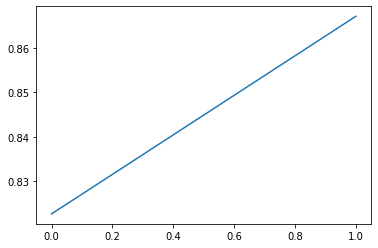

In [15]:
for k in all_res.keys():
  means = np.mean(np.array([(x[-1],np.max(y)) for x,y in all_res[k]]), axis=0)
  # stds = np.std(np.array([(x[0][-1],np.max(y)) for x,y in all_res[k] ]), axis=0)
  plt.plot(means)

In [16]:
means

array([0.82263667, 0.86711667])

In [ ]:
for k in all_res.keys():
  means = np.mean(np.array([(x[0][-1],y) for x,y in all_res[k] ]), axis=0)
  stds = np.std(np.array([(x[0][-1],y) for x,y in all_res[k] ]), axis=0)
  plt.plot(means)


In [ ]:
sol_3

In [ ]:
# FLOPS
# http://www.bnikolic.co.uk/blog/python/flops/2019/10/01/pytorch-count-flops.html

In [ ]:
aa = {2:'a'}

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
colors = ['blue', 'red', 'green', ]
for idx,i in enumerate([7,14,28]):
  plt.plot(np.log(pars[ress==i]), score[ress==i] , 'o', color = colors[idx])

plt.legend(['res = 7', 'res = 14', 'res = 28'])

In [ ]:
colors = ['blue', 'red', 'green', ]
for idx,i in enumerate([7,14,28]):
  plt.plot(np.log(flops[ress==i]), score[ress==i] , 'o', color = colors[idx])

plt.legend(['res = 7', 'res = 14', 'res = 28'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ls MyDrive/

In [ ]:
cd drive/

In [ ]:
# cd /MyDrive/classification_images/Pairwise
!cd MyDrive/ClassificationImages/Pairwise/

In [ ]:
# from google.colab import files
# # 
# with open('example.txt', 'w') as f:
#   f.write('some content')

# files.download('example.txt')



# with open('MyDrive/ClassificationImages/Pairwise/accs_mnist.npz', 'w') as f:
np.savez('MyDrive/ClassificationImages/Pairwise/accs_fmnist.npz', accs)


In [ ]:
# with open('MyDrive/ClassificationImages/Pairwise/accs_mnist.npz') as f:
dd = np.load('MyDrive/ClassificationImages/Pairwise/accs_mnist.npz')

In [ ]:
# accs = dd['arr_0']

In [ ]:
def test_f(aa):
  aa.append(10)

  return

q = [1]
test_f(q)
print(q)


In [ ]:
torch.__version__
